# Value at Risk

## Method 1: Historical Bootstrap

In [3]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline 
import datetime
from datetime import date, datetime, time
import yfinance as yf

In [6]:
# This method creates a distribution from historical data, then uses this distribution to calculate the VAR

# Let's get BHP data for this example

df = yf.download("BHP", start = "2010-01-01", end = "2023-12-31")

# We are interested in the percentage change for the stock

df2 = df['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


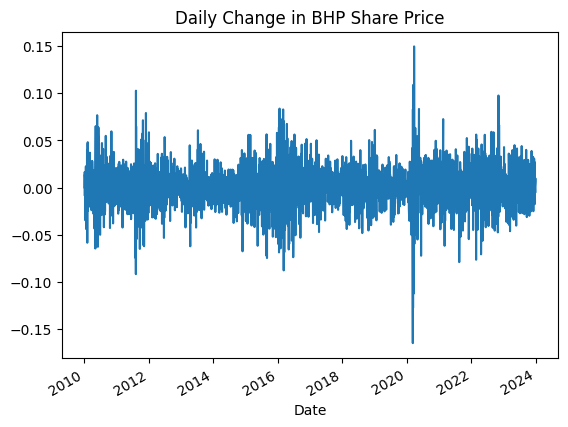

In [8]:
# Lets plot these changes quickly

plt.figure()
df2.plot()
plt.title("Daily Change in BHP Share Price")
plt.show()

# Now, we want to create this as a distribution

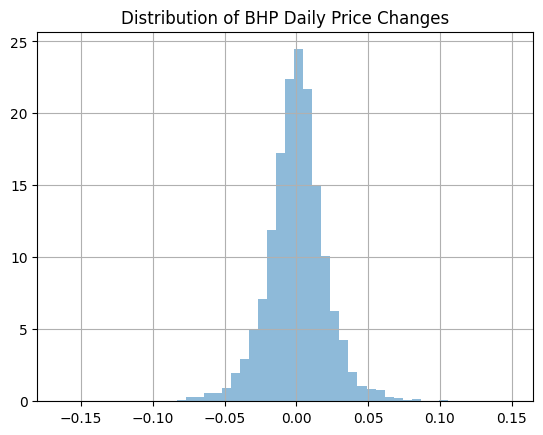

In [10]:
df2.hist(bins = 50, density=True, histtype='stepfilled', alpha=0.5)
plt.title("Distribution of BHP Daily Price Changes")
plt.show()

In [11]:
# To get the 5% value at risk, we simply draw the 5th percentile from this distribution
var_bootstrap = df2.quantile(0.05)

print(f'The one day 5% VaR for BHP is {var_bootstrap:.4f}. \n'
      f'That is, over a given day, there is a 5% chance that a {var_bootstrap * 100:.2f}% loss will be incurred.')

The one day 5% VaR for BHP is -0.0327. 
That is, over a given day, there is a 5% chance that a -3.27% loss will be incurred.


## Method 2: Variance Covariance Method

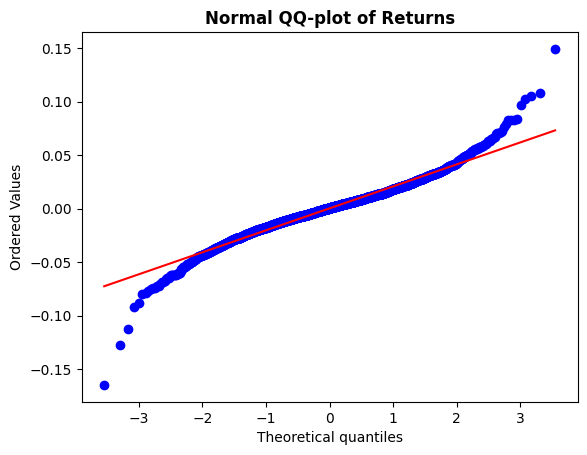

In [12]:
# This method uses a satistical distribution to calculate the VAR
# First we need to determine what distribution may be appropriate for BHP's returns. We will do this with a QQ plot
# First we look at a normal distribution

scipy.stats.probplot(df2, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title("Normal QQ-plot of Returns", weight="bold")
plt.show()

# We want each of the dots to lie on the red line

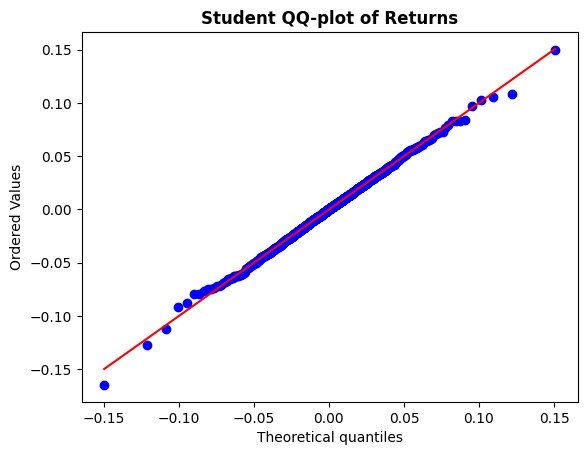

In [14]:
# Next we use a Student-T distribution, which requires some additional calculations

tdf, tmean, tsigma = scipy.stats.t.fit(df2)
scipy.stats.probplot(df2, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title("Student QQ-plot of Returns", weight="bold")
plt.show()

# The student distribution is much better, so we will utilise this

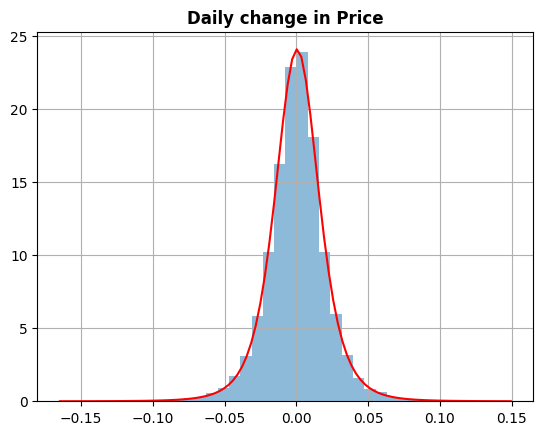

In [15]:
# Lets plot the probability density function for the BHP returns

support = np.linspace(df2.min(), df2.max(), 100)
df2.hist(bins=40, density=True, histtype='stepfilled', alpha=0.5);
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title("Daily change in Price", weight='bold')
plt.show()

In [16]:
# Now to calculate the 5% VAR, we simply take the probability (area) at and below 5%

var_parametric = scipy.stats.t.ppf(0.05, loc = tmean, scale = tsigma, df = tdf)

print(f'The one day 5% VaR for BHP is {var_parametric:.4f}. \n'
      f'That is, over a given day, there is a 5% chance that a {var_parametric * 100:.2f}% loss will be incurred.')

The one day 5% VaR for BHP is -0.0320. 
That is, over a given day, there is a 5% chance that a -3.20% loss will be incurred.


## Method 3: Monte Carlo

In [17]:
# We can also use Monte Carlo to calculate a VaR. This method assumes stock prices follow a random walk (Brownian motion). We need to define 4 parameters:

sigma = df2.std() # volatility, or standard deviation
mu = df2.mean() # the 'drift', or average growth rate
startprice = df["Adj Close"][0]

C:\Users\PC\AppData\Local\Temp\ipykernel_16408\974423646.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  startprice = df["Adj Close"][0]


In [18]:
# We will also set a seed for our random numbers, to allow for replicable results

rng = np.random.default_rng(seed = 1000)

In [19]:
# We now create a function which simulates the random walk

def random_walk(startprice: float, 
                time: float,
                sigma: float,
                mu: float,
                steps: int,
                n_sims: int):
    
    # Define length of time steps
    dt = time/steps

    # Calculate an array of price paths using GBM

    paths = startprice * np.exp(np.cumsum((mu - sigma**2/2)*dt + \
                                          sigma*np.sqrt(dt) * \
                                            rng.normal(size  = [steps, n_sims]), axis = 0))
    

    return paths

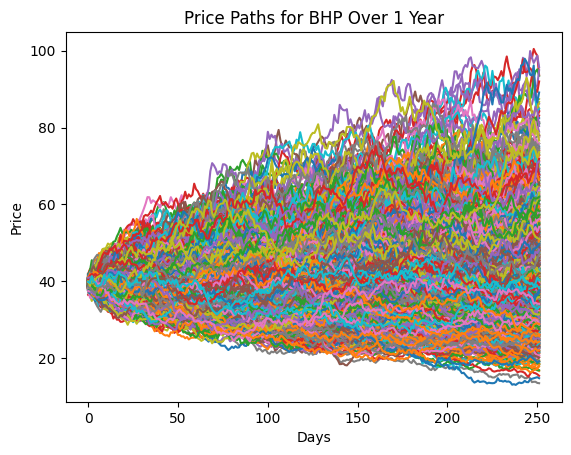

In [20]:
# Lets run 100 of these simulations as a test

# Below, we use 252 for time. This will simulate one year, as our data is daily. We will also do one day per step.

paths = random_walk(startprice = startprice,
                    time = 252,
                    sigma = sigma,
                    mu = mu,
                    steps = 252,
                    n_sims = 1000)

plt.plot(paths)
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Price Paths for BHP Over 1 Year")
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_16408\2759414856.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.figtext(0.6, 0.8, f"Start price: ${round(df['Adj Close'][0],2)}")
C:\Users\PC\AppData\Local\Temp\ipykernel_16408\2759414856.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.figtext(0.6, 0.6, f"VaR(0.95): ${round(df['Adj Close'][0] - q,2)}") #3 Update starting price here


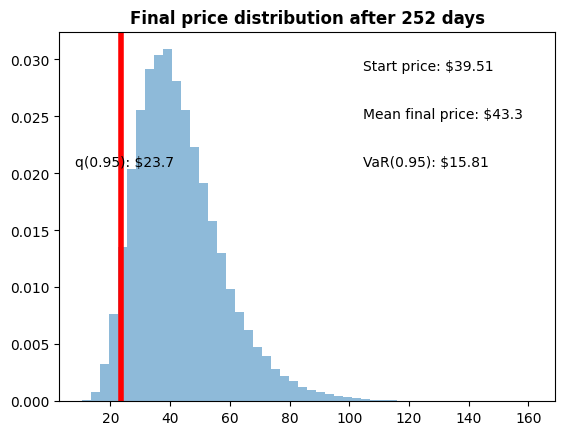

In [23]:
# Now lets use this function to calculate our VAR, using 100,000 simulations

paths = random_walk(startprice = startprice,
                    time = 252,
                    sigma = sigma,
                    mu = mu,
                    steps = 252,
                    n_sims = 100_000)[-1] # Get the terminal prices
q = np.percentile(paths, 5) # calculate the 5th percentile
plt.hist(paths, density=True, bins=50, histtype='stepfilled', alpha=0.5)
plt.figtext(0.6, 0.8, f"Start price: ${round(df['Adj Close'][0],2)}") 
plt.figtext(0.6, 0.7, f"Mean final price: ${round(paths.mean(),2)}")
plt.figtext(0.6, 0.6, f"VaR(0.95): ${round(df['Adj Close'][0] - q,2)}") #3 Update starting price here
plt.figtext(0.15, 0.6, f"q(0.95): ${round(q,2)}")
plt.axvline(x=q, linewidth=4, color='r')
plt.title(f"Final price distribution after 252 days", weight='bold')
plt.show()

In [24]:
print(f"The one year 5% VaR is ${round(df['Adj Close'][0] - q,2)}. \n"
      f"That is, over a year, there is a 5% chance that a ${round(df['Adj Close'][0] - q,2)} loss will be incurred.")

The one year 5% VaR is $15.81. 
That is, over a year, there is a 5% chance that a $15.81 loss will be incurred.


C:\Users\PC\AppData\Local\Temp\ipykernel_16408\1937015227.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"The one year 5% VaR is ${round(df['Adj Close'][0] - q,2)}. \n"
C:\Users\PC\AppData\Local\Temp\ipykernel_16408\1937015227.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"That is, over a year, there is a 5% chance that a ${round(df['Adj Close'][0] - q,2)} loss will be incurred.")
